In [1]:
import torch
import numpy as np
from NLPUtils.DataModel import Vocabulary
from torch.utils.data import DataLoader, TensorDataset
import pickle

c:\Users\Wen2Tee5\Desktop\Postgraduate\torchPlayGround\torchEnv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('./SLTCDataset/mr/train_voc.data', 'rb') as f:
    train_voc : Vocabulary = pickle.load(f)
x_train = np.load('./SLTCDataset/mr/x_train.npy')
y_train = np.load('./SLTCDataset/mr/y_train.npy')
x_test = np.load('./SLTCDataset/mr/x_test.npy')
y_test = np.load('./SLTCDataset/mr/y_test.npy')

In [3]:
trainDataset = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
testDataset = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))

In [4]:
trainDataLoader = DataLoader(trainDataset, batch_size = 32, shuffle=True)

In [5]:
class LSTMBased(torch.nn.Module):

    def __init__(self, train_voc) -> None:
        super(LSTMBased, self).__init__()
        self.embedding = torch.nn.Embedding(train_voc.num_words, 300, padding_idx = 0)
        self.lstm1 = torch.nn.LSTM(input_size = 300, hidden_size = 300, batch_first = True)
        self.linear_d = torch.nn.Linear(30 * 300, 128)
        self.linear_i = torch.nn.Linear(128, 2)
    def forward(self, x):
        h = self.embedding(x)
        h, (_, _) = self.lstm1(h)
        h = torch.nn.functional.relu(h)
        h = torch.flatten(h, start_dim = 1)
        h = self.linear_d(h)
        h = torch.nn.functional.relu(h)
        h = self.linear_i(h)
        return h

In [6]:
model = LSTMBased(train_voc = train_voc).cuda()
loss_fn = torch.nn.CrossEntropyLoss()
otim = torch.optim.Adam(model.parameters())
losses = []

In [7]:
for ep in range(20):
    for x, y in trainDataLoader:
        x, y = x.cuda(), y.cuda()
        otim.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        otim.step()
    losses.append(loss.item())

In [8]:
import matplotlib.pyplot as plt

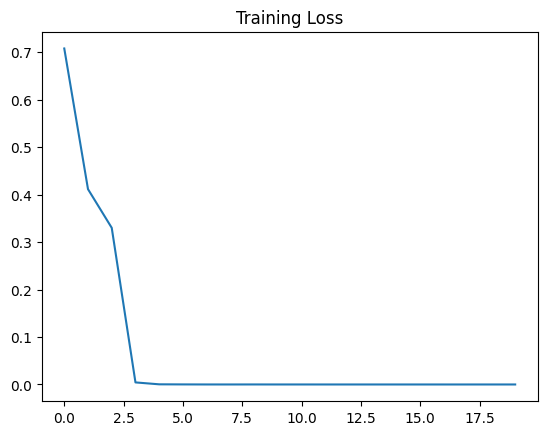

In [9]:
plt.plot(losses)
plt.title("Training Loss")
plt.show()

In [15]:
with torch.no_grad():
    x, y = testDataset.tensors[0].cuda(), testDataset.tensors[1].cuda()
    pred = model(x)
    count = (pred.argmax(1) == y).sum().float()
    print(count / len(testDataset))

tensor(0.7040, device='cuda:0')
